In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

main_experiments_path = "../experiments"
housing_experiment_path = "../../15_incremental_rbf_housing/experiments"

main_experiments = []


method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp_0.01",
    "mlp_0.001",
    "mlp_0.0001",
    "rbf_full_0.01",
    "rbf_full_0.001",
    "rbf_full_0.0001",
    "rbf_diag_0.01",
    "rbf_diag_0.001",
    "rbf_diag_0.0001",
    "rbf_scal_0.01",
    "rbf_scal_0.001",
    "rbf_scal_0.0001",
    "rbf_univ_0.01",
    "rbf_univ_0.001",
    "rbf_univ_0.0001",
    "ffn_0.1_0.01",
    "ffn_0.1_0.001",
    "ffn_0.1_0.0001",
    "ffn_1_0.01",
    "ffn_1_0.001",
    "ffn_1_0.0001",
    "ffn_10_0.01",
    "ffn_10_0.001",
    "ffn_10_0.0001",
    "uffn_0.1_0.01",
    "uffn_0.1_0.001",
    "uffn_0.1_0.0001",
    "uffn_1_0.01",
    "uffn_1_0.001",
    "uffn_1_0.0001",
    "uffn_10_0.01",
    "uffn_10_0.001",
    "uffn_10_0.0001",
]


condensed_method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp",
    "rbf_full",
    "rbf_diag",
    "rbf_scal",
    "rbf_univ",
    "ffn",
    "uffn",
]


repetition_ids = list(range(8))
learning_rates = ["0.01", "0.001", "0.0001"]
scales = ["0.1", "1", "10"]
datasets = []
experiments_data = None

method_settings = os.listdir(main_experiments_path)

# sort by name
method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_folder in method_settings:
    # iterate over repetitions

    if method_folder.startswith("."):
        continue

    for repetition_folder in os.listdir(main_experiments_path + "/" + method_folder):
        # iterate over files

        if repetition_folder.startswith("."):
            continue

        ## add this repetition to the experiment df as column

        dataset_folders = os.listdir(main_experiments_path + "/" + method_folder + "/" + repetition_folder)
        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)
        dataset_folders = [dataset_folder for dataset_folder in dataset_folders if not dataset_folder.startswith(".") and dataset_folder != "data" and "data" in dataset_folder] 

        if experiments_data is None:
            datasets = [*dataset_folders, "housing"]
            datasets = [dataset.replace("data", "") for dataset in datasets]
            experiments_data = xr.DataArray(np.zeros((len(datasets),len(condensed_method_names), len(repetition_ids), len(learning_rates), len(scales))) - 1, coords=[datasets, condensed_method_names, repetition_ids, learning_rates, scales], dims=['datasets','method', 'repetition','lr','scales'])


        for dataset_folder in dataset_folders:
            ## add this dataset to the experiments data array if it is not already there

            try:
                ## read the npy file
                train_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder+ "/" + "train_loss.npy")
                val_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "val_loss.npy")
                test_loss = np.load(main_experiments_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "test_loss.npy")
            except Exception as e:
                print("Error reading files for dataset: ", dataset_folder, e)
                continue
            
            ### extract the min val loss and pick the corresponding test loss

            min_val_loss = np.min(val_loss)
            min_val_loss_index = np.argmin(val_loss)

            min_test_loss = test_loss[min_val_loss_index]
            method_folder_id = int(method_folder.split("_")[1])

            method_description = method_names[method_folder_id - 1]
            method_parts = method_description.split("_")

            #data_dim = int(method_parts[0])
            method_name = method_parts[0]

            repetition_id = int(repetition_folder.split("_")[1])

            scale = None
            lr = None

            if method_name == "rbf":
                method_name = method_name + "_" + method_parts[1]
                lr = method_parts[-1]
            elif method_name == "ffn" or method_name == "uffn":
                scale = method_parts[1]
                lr = method_parts[-1]
            elif method_name == "mlp":
                lr = method_parts[-1]
                

            dataset_name = dataset_folder.replace("data", "")

            if lr is None:
                experiments_data.loc[dataset_name, method_name, repetition_id, :,:] = min_test_loss
            elif lr is not None and scale is None:
                experiments_data.loc[dataset_name, method_name, repetition_id, lr,:] = min_test_loss
            else:
                experiments_data.loc[dataset_name, method_name, repetition_id, lr, scale] = min_test_loss




method_settings = os.listdir(housing_experiment_path)

# exclude folders beginning with . (e.g. .DS_Store)
method_settings = [method_setting for method_setting in method_settings if not method_setting.startswith(".")]

# sort by name
method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_folder in method_settings:
    # iterate over repetitions

    if method_folder.startswith("."):
        continue

    for repetition_folder in os.listdir(housing_experiment_path + "/" + method_folder):

        ## exclude folders beginning with . (e.g. .DS_Store)
        if repetition_folder.startswith("."):
            continue

        # iterate over files

        dataset_folders = os.listdir(housing_experiment_path + "/" + method_folder + "/" + repetition_folder)

        ## sort the dataset folders by name
        dataset_folders = sorted(dataset_folders)

        dataset_folder = "data"
        dataset_name = "housing"

        try:
            ## read the npy file
            train_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder+ "/" + "train_loss.npy")
            val_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "val_loss.npy")
            test_loss = np.load(housing_experiment_path + "/" + method_folder + "/" + repetition_folder + "/" + dataset_folder + "/" + "test_loss.npy")
        except Exception as e:
            print("Error reading files for dataset: ", dataset_name, e)
            continue

        ### extract the min val loss and pick the corresponding test loss
        min_val_loss = np.min(val_loss)
        min_val_loss_index = np.argmin(val_loss)

        min_test_loss = test_loss[min_val_loss_index]

        method_folder_id = int(method_folder.split("_")[1])

        method_description = method_names[method_folder_id - 1]
        method_parts = method_description.split("_")

        method_name = method_parts[0]

        repetition_id = int(repetition_folder.split("_")[1])

        scale = None
        lr = None

        print("method_name",method_name)

        if method_name == "rbf":
            method_name = method_name + "_" + method_parts[1]
            lr = method_parts[-1]
        elif method_name == "ffn" or method_name == "uffn":
            scale = method_parts[1]
            lr = method_parts[-1]
        elif method_name == "mlp":
            lr = method_parts[-1]
            

        #dataset_name = dataset_folder.replace("data", "")

        print(dataset_name)

        if lr is None:
            experiments_data.loc[dataset_name, method_name, repetition_id, :,:] = min_test_loss
        elif lr is not None and scale is None:
            experiments_data.loc[dataset_name, method_name, repetition_id, lr,:] = min_test_loss
        else:

            experiments_data.loc[dataset_name, method_name, repetition_id, lr, scale] = min_test_loss


experiments_data = experiments_data.sortby("datasets")

experiments_data

method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name svr
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name pls
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name gradboost
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp
housing
method_name mlp


<xarray.DataArray (datasets: 20, method: 10, repetition: 8, lr: 3, scales: 3)> Size: 115kB
array([[[[[3.48298303e-01, 3.48298303e-01, 3.48298303e-01],
          [3.48298303e-01, 3.48298303e-01, 3.48298303e-01],
          [3.48298303e-01, 3.48298303e-01, 3.48298303e-01]],

         [[3.03191444e-01, 3.03191444e-01, 3.03191444e-01],
          [3.03191444e-01, 3.03191444e-01, 3.03191444e-01],
          [3.03191444e-01, 3.03191444e-01, 3.03191444e-01]],

         [[3.53749366e-01, 3.53749366e-01, 3.53749366e-01],
          [3.53749366e-01, 3.53749366e-01, 3.53749366e-01],
          [3.53749366e-01, 3.53749366e-01, 3.53749366e-01]],

         ...,

         [[2.57550246e-01, 2.57550246e-01, 2.57550246e-01],
          [2.57550246e-01, 2.57550246e-01, 2.57550246e-01],
          [2.57550246e-01, 2.57550246e-01, 2.57550246e-01]],

         [[3.23077170e-01, 3.23077170e-01, 3.23077170e-01],
          [3.23077170e-01, 3.23077170e-01, 3.23077170e-01],
...
          [2.41148790e-01, 1.78014136e-01, 2.04456137e-01],
          [2.97199666e-01, 1.78974810e-01, 1.86774475e-01]],

         [[2.40295115e-01, 2.14218580e-01, 2.08313361e-01],
          [2.08148520e-01, 1.77116759e-01, 2.13533591e-01],
          [2.50331012e-01, 1.96996817e-01, 2.10778622e-01]],

         ...,

         [[2.66018941e-01, 1.94017967e-01, 2.21563073e-01],
          [2.43097940e-01, 1.90481436e-01, 2.20048727e-01],
          [2.61891020e-01, 1.98043001e-01, 2.19830008e-01]],

         [[2.12163812e-01, 1.88349728e-01, 1.74249401e-01],
          [2.29302658e-01, 1.72581873e-01, 1.83870916e-01],
          [2.43812958e-01, 1.79191603e-01, 1.73734506e-01]],

         [[1.92013409e-01, 1.72154109e-01, 2.49176377e-01],
          [2.05000418e-01, 1.66535105e-01, 2.39389223e-01],
          [2.19970814e-01, 1.77317728e-01, 2.57239890e-01]]]]])
Coordinates:
  * datasets    (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
  * method      (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * repetition  (repetition) int64 64B 0 1 2 3 4 5 6 7
  * lr          (lr) <U6 72B '0.01' '0.001' '0.0001'
  * scales      (scales) <U3 36B '0.1' '1' '10'

In [38]:
_experiments_data = experiments_data.copy()


repetition_datasets_mean_data = _experiments_data.mean(dim=['datasets', 'repetition'])

## normalize the data by the mlp mean

min_mlp_mean = repetition_datasets_mean_data.sel(dict(method="mlp")).min()
repetition_datasets_mean_data = repetition_datasets_mean_data / min_mlp_mean
_experiments_data = _experiments_data / min_mlp_mean


repetition_datasets_std_data = _experiments_data.std(dim=['datasets', 'repetition'])

repetition_dim_summary_data = xr.concat([repetition_datasets_mean_data, repetition_datasets_std_data], dim= pd.Index(["mean", "std"], name='summary'))

means = repetition_dim_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim='lr')
min_mean_index = min_mean_index.drop_vars('summary')
min_mean_index = min_mean_index.squeeze()


collapsed_repetition_datasets_summary_data = repetition_dim_summary_data.isel(lr=min_mean_index, missing_dims="ignore")
collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.drop_vars(['lr'])



means = collapsed_repetition_datasets_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim='scales')
min_mean_index = min_mean_index.drop_vars('summary')
min_mean_index = min_mean_index.squeeze()

collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.isel(scales=min_mean_index, missing_dims="ignore")
collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.drop_vars(['scales'])




collapsed_repetition_datasets_summary_data



<xarray.DataArray (summary: 2, method: 10)> Size: 160B
array([[ 4.03176292,  3.73973839,  0.52850495,  1.        ,  0.69184172,
         0.69184172,  3.68135485,  0.56623875,  3.78380297,  0.60964801],
       [20.68955466, 18.95531158,  2.76335186,  5.79073615,  3.37969724,
         3.37969724, 19.11279724,  2.92647589, 19.37481569,  2.93924593]])
Coordinates:
  * method   (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * summary  (summary) object 16B 'mean' 'std'

In [39]:
_experiments_data = experiments_data.copy()

### average over repetitions and pick the min value across learning rates
repetition_mean_data = _experiments_data.mean(dim='repetition')
min_mlp_mean = repetition_mean_data.sel(dict(method="mlp")).min(dim=['lr', 'scales'])

print("min mlp ",min_mlp_mean.shape, "min mlp", min_mlp_mean)
repetition_mean_data = repetition_mean_data / min_mlp_mean

_experiments_data = _experiments_data / min_mlp_mean 
repetition_std_data = _experiments_data.std(dim='repetition')

## combine mean and std into one xarray

repetition_summary_data = xr.concat([repetition_mean_data, repetition_std_data], dim= pd.Index(["mean", "std"], name='summary'))

### now keep the min mean value across learning rates for each method and data dimension combination and also keep the corresponding std value 
#min_mean_lr = repetition_summary_data.loc[dict(summary='mean')].argmin(dim='lr')

means = repetition_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim='lr')
min_mean_index = min_mean_index.drop_vars('summary')
min_mean_index = min_mean_index.squeeze()

collapsed_repetition_summary_data = repetition_summary_data.isel(lr=min_mean_index, missing_dims="ignore")
collapsed_repetition_summary_data = collapsed_repetition_summary_data.drop_vars(['lr'])


means = collapsed_repetition_summary_data.sel(summary="mean")
min_mean_index = means.argmin(dim='scales')
min_mean_index = min_mean_index.drop_vars('summary')
min_mean_index = min_mean_index.squeeze()

collapsed_repetition_summary_data = collapsed_repetition_summary_data.isel(scale=min_mean_index, missing_dims="ignore")
collapsed_repetition_summary_data = collapsed_repetition_summary_data.drop_vars(['scales'])




collapsed_repetition_summary_data

min mlp  (20,) min mlp <xarray.DataArray (datasets: 20)> Size: 160B
array([2.86590995e-01, 7.33001795e-01, 5.14709380e+00, 3.92013711e+00,
       9.68640381e+00, 2.04086761e-01, 1.56340895e+02, 3.37324695e+04,
       2.30656621e+00, 1.16255878e+00, 1.32691063e+01, 2.63824112e+06,
       9.05733728e-02, 6.01775607e+00, 1.16301638e+01, 1.07478948e+02,
       7.91430180e+02, 3.98370852e+01, 5.98384442e-01, 1.79622292e-01])
Coordinates:
  * datasets  (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
    method    <U9 36B 'mlp'


<xarray.DataArray (summary: 2, datasets: 20, method: 10, scales: 3)> Size: 10kB
array([[[[1.11808025e+00, 1.11808025e+00, 1.11808025e+00],
         [9.73209850e-01, 9.73209850e-01, 9.73209850e-01],
         [1.13994173e+00, 1.13994173e+00, 1.13994173e+00],
         ...,
         [1.08672259e+00, 1.08672259e+00, 1.08672259e+00],
         [1.28722653e+00, 6.62666012e+00, 6.13154376e+00],
         [1.12097368e+00, 1.16245213e+00, 1.20450303e+00]],

        [[5.20332418e-01, 5.20332418e-01, 5.20332418e-01],
         [5.10637029e-01, 5.10637029e-01, 5.10637029e-01],
         [5.37392795e-01, 5.37392795e-01, 5.37392795e-01],
         ...,
         [1.02537955e+00, 1.02537955e+00, 1.02537955e+00],
         [1.10789990e+00, 1.24062714e+00, 1.18925676e+00],
         [1.01173679e+00, 1.01706181e+00, 1.02104234e+00]],

        [[5.24513761e-01, 5.24513761e-01, 5.24513761e-01],
         [5.05923374e-01, 5.05923374e-01, 5.05923374e-01],
         [5.32319587e-01, 5.32319587e-01, 5.32319587e-01],
         ...,
...
         ...,
         [1.61666404e-01, 1.61666404e-01, 1.61666404e-01],
         [2.47038674e-01, 8.16701466e-01, 7.32312394e-01],
         [1.49027654e-01, 3.02634622e-01, 1.36238227e+00]],

        [[5.50709065e-03, 5.50709065e-03, 5.50709065e-03],
         [2.16419884e-03, 2.16419884e-03, 2.16419884e-03],
         [5.31382953e-03, 5.31382953e-03, 5.31382953e-03],
         ...,
         [7.92013928e-02, 7.92013928e-02, 7.92013928e-02],
         [6.33391566e-02, 1.23012959e-01, 1.35981751e-01],
         [7.69932249e-02, 7.81436059e-02, 6.90160210e-01]],

        [[3.37738304e-03, 3.37738304e-03, 3.37738304e-03],
         [7.05603591e-01, 7.05603591e-01, 7.05603591e-01],
         [3.11546804e-03, 3.11546804e-03, 3.11546804e-03],
         ...,
         [8.06656221e-02, 8.06656221e-02, 8.06656221e-02],
         [1.59365075e-01, 1.70949287e-01, 8.55384728e-02],
         [9.42731524e-02, 6.97223567e-02, 1.35067912e-01]]]])
Coordinates:
  * datasets  (datasets) <U29 2kB '1027_ESL' '1029_LEV' ... 'banana' 'housing'
  * method    (method) <U9 360B 'svr' 'pls' 'gradboost' ... 'ffn' 'uffn'
  * summary   (summary) object 16B 'mean' 'std'
Dimensions without coordinates: scales

In [40]:
method_renaming = {
    "svr": "SVR",
    "gradboost": "GradBoost",
    "mlp": "MLP",
    "rbf_full": "RBF Full",
    "rbf_diag": "RBF Diag",
    "rbf_scal": "RBF Scal",
    "rbf_univ": "U-RBF",
    "ffn": "FFM",
    "uffn": "U-FFM",
}

### rename the method coords and only keep the methods that have a mapping

collapsed_repetition_summary_data = collapsed_repetition_summary_data.sel(dict(method=[key for key in method_renaming.keys() if key in collapsed_repetition_summary_data.method.values]))#.sel(method=[key for key in method_renaming.keys() if key in method_renaming.keys()])
collapsed_repetition_summary_data.coords['method'] = [method_renaming[method] for method in collapsed_repetition_summary_data.method.values]


mean_summary_data = collapsed_repetition_summary_data.sel(summary="mean")
std_summary_data = collapsed_repetition_summary_data.sel(summary="std") 



mean_df = mean_summary_data.to_dataframe(name='value').reset_index()
mean_df = mean_df.pivot_table(index='datasets', columns='method', values='value', aggfunc=lambda x: list(x)[0])

std_df = std_summary_data.to_dataframe(name='value').reset_index()
std_df = std_df.pivot_table(index='datasets', columns='method', values='value', aggfunc=lambda x: list(x)[0])


## rename the row index 
mean_df.index = [str(dim) + " m"  for dim in mean_df.index]

std_df.index = [str(dim) + " s"  for dim in std_df.index]


### merge the mean and std dataframes into one and alternate the rows

final_df = pd.concat([mean_df, std_df], axis=0)
final_df = final_df.sort_index()

### add the average row at the end

collapsed_repetition_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(dict(method=[key for key in method_renaming.keys() if key in collapsed_repetition_datasets_summary_data.method.values]))#.sel(method=[key for key in method_renaming.keys() if key in method_renaming.keys()])
collapsed_repetition_datasets_summary_data.coords['method'] = [method_renaming[method] for method in collapsed_repetition_datasets_summary_data.method.values]

mean_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(summary="mean")
std_datasets_summary_data = collapsed_repetition_datasets_summary_data.sel(summary="std")

mean_datasets_summary_data = mean_datasets_summary_data.to_dataframe(name='value').reset_index()
mean_datasets_summary_data = mean_datasets_summary_data.pivot_table( columns='method', values='value', aggfunc=lambda x: list(x)[0])

std_datasets_summary_data = std_datasets_summary_data.to_dataframe(name='value').reset_index()
std_datasets_summary_data = std_datasets_summary_data.pivot_table( columns='method', values='value', aggfunc=lambda x: list(x)[0])


## rename the row index
mean_datasets_summary_data.index = [str(dim) + " m"  for dim in mean_datasets_summary_data.index]
std_datasets_summary_data.index = [str(dim) + " s"  for dim in std_datasets_summary_data.index]


final_datasets_summary_df = pd.concat([mean_datasets_summary_data, std_datasets_summary_data], axis=0)
final_datasets_summary_df = final_datasets_summary_df.sort_index()

final_df = pd.concat([final_df, final_datasets_summary_df], axis=0)


### sort the methods according to the order in the method names list

final_df = final_df[method_renaming.values()]

final_df

method,SVR,GradBoost,MLP,RBF Full,RBF Diag,RBF Scal,U-RBF,FFM,U-FFM
1027_ESL m,1.118080,1.139942,1.000000,0.969669,0.969669,0.954458,1.086723,1.287227,1.120974
1027_ESL s,0.112047,0.114022,0.182500,0.110322,0.110322,0.093244,0.186803,0.249754,0.131169
1029_LEV m,0.520332,0.537393,1.000000,1.022751,1.022751,1.017935,1.025380,1.107900,1.011737
1029_LEV s,0.076944,0.068134,0.100182,0.125691,0.125691,0.106225,0.103018,0.170809,0.129978
1030_ERA m,0.524514,0.532320,1.000000,1.004468,1.004468,1.016899,1.044450,1.070933,1.030867
1030_ERA s,0.048284,0.057138,0.099749,0.094676,0.094676,0.096931,0.104099,0.111071,0.112678
1096_FacultySalaries m,4.772892,1.796605,1.000000,1.252620,1.252620,1.226222,1.176795,10.091780,5.458740
1096_FacultySalaries s,0.895344,0.603406,0.254442,0.544230,0.544230,0.623987,0.419599,4.134778,3.462618
192_vineyard m,0.911293,1.172247,1.000000,2.243519,2.243519,2.255330,0.809360,0.988860,1.078004
192_vineyard s,0.728675,0.482676,0.392913,3.469164,3.469164,3.463639,0.270771,0.599014,0.492160


In [41]:
## print the final df to a latex table

formatted_df = final_df.copy()

### format the values to 2 decimal places
formatted_df = formatted_df.map(lambda x: "{:.2f}".format(x))

## all rows that end with s in the index need values with brackets around them

formatted_df.loc[formatted_df.index.str.endswith(" s"), :] = formatted_df.loc[formatted_df.index.str.endswith(" s"), :].map(lambda x: "(± " + x + ")")

formatted_df.index = ["" if dim.endswith(" s") else "\multirow{2}{*}{" +dim.replace(' m','')+"}" for dim in formatted_df.index]

formatted_df.index = [dim.replace("value", "average") for dim in formatted_df.index]


latex = formatted_df.to_latex(float_format="%.2f", escape=False, column_format="l" + "c" * formatted_df.shape[1])

latex = latex.replace("_", "\_")
latex = latex.replace("method", "")

print(latex)

\begin{tabular}{lccccccccc}
\toprule
 & SVR & GradBoost & MLP & RBF Full & RBF Diag & RBF Scal & U-RBF & FFM & U-FFM \\
\midrule
\multirow{2}{*}{1027\_ESL} & 1.12 & 1.14 & 1.00 & 0.97 & 0.97 & 0.95 & 1.09 & 1.29 & 1.12 \\
 & (± 0.11) & (± 0.11) & (± 0.18) & (± 0.11) & (± 0.11) & (± 0.09) & (± 0.19) & (± 0.25) & (± 0.13) \\
\multirow{2}{*}{1029\_LEV} & 0.52 & 0.54 & 1.00 & 1.02 & 1.02 & 1.02 & 1.03 & 1.11 & 1.01 \\
 & (± 0.08) & (± 0.07) & (± 0.10) & (± 0.13) & (± 0.13) & (± 0.11) & (± 0.10) & (± 0.17) & (± 0.13) \\
\multirow{2}{*}{1030\_ERA} & 0.52 & 0.53 & 1.00 & 1.00 & 1.00 & 1.02 & 1.04 & 1.07 & 1.03 \\
 & (± 0.05) & (± 0.06) & (± 0.10) & (± 0.09) & (± 0.09) & (± 0.10) & (± 0.10) & (± 0.11) & (± 0.11) \\
\multirow{2}{*}{1096\_FacultySalaries} & 4.77 & 1.80 & 1.00 & 1.25 & 1.25 & 1.23 & 1.18 & 10.09 & 5.46 \\
 & (± 0.90) & (± 0.60) & (± 0.25) & (± 0.54) & (± 0.54) & (± 0.62) & (± 0.42) & (± 4.13) & (± 3.46) \\
\multirow{2}{*}{192\_vineyard} & 0.91 & 1.17 & 1.00 & 2.24 & 2.24 & 2.26 &

Coordinates:
  * summary  (summary) object 16B 'mean' 'std'
  * method   (method) <U9 324B 'SVR' 'GradBoost' 'MLP' ... 'U-RBF' 'FFM' 'U-FFM'
              value
method             
SVR        4.031763
GradBoost  0.528505
MLP        1.000000
RBF Full   0.691842
RBF Diag   0.691842
RBF Scal   3.681355
U-RBF      0.566239
FFM        3.783803
U-FFM      0.609648


/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_13453/1019997741.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


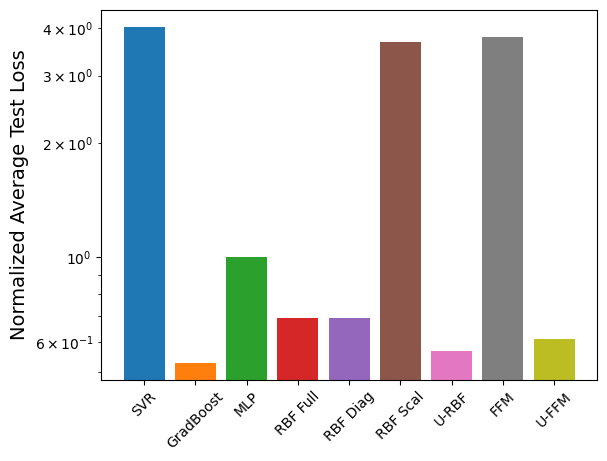

In [42]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

print(collapsed_repetition_datasets_summary_data.coords)


mean_repetition_datasets_df = collapsed_repetition_datasets_summary_data.sel(summary="mean").to_dataframe(name='value').reset_index()
mean_repetition_datasets_df = mean_repetition_datasets_df.pivot_table(index='method',  values='value', aggfunc=lambda x: list(x)[0])
#mean_repetition_datasets_df = mean_repetition_datasets_df.drop("pls")

mean_repetition_datasets_df = mean_repetition_datasets_df.rename(index=method_renaming)
## sort the index by the order in the method names list
mean_repetition_datasets_df = mean_repetition_datasets_df.reindex(method_renaming.values())


## normalize the data by the mlp value
mean_repetition_datasets_df = mean_repetition_datasets_df / mean_repetition_datasets_df.loc["MLP"]



print(mean_repetition_datasets_df)

###               value
# method             
# SVR        4.031763
# GradBoost  0.528505
# MLP        1.000000
# RBF Full   0.691842
# RBF Diag   0.691842
# RBF Scal   3.681355
# U-RBF      0.566239
# FFM        3.796245
# U-FFM      0.662704


## plot this in a colored bar chart
plt.bar(mean_repetition_datasets_df.index, mean_repetition_datasets_df.value, color=colors)

plt.ylabel("Normalized Average Test Loss",fontsize=14)
plt.yscale("log")
plt.ylim(bottom=0)
plt.xticks(rotation=45)

plt.savefig("../../../assets/v2full_dataset_summary.pdf", format="pdf", bbox_inches='tight')


plt.show()






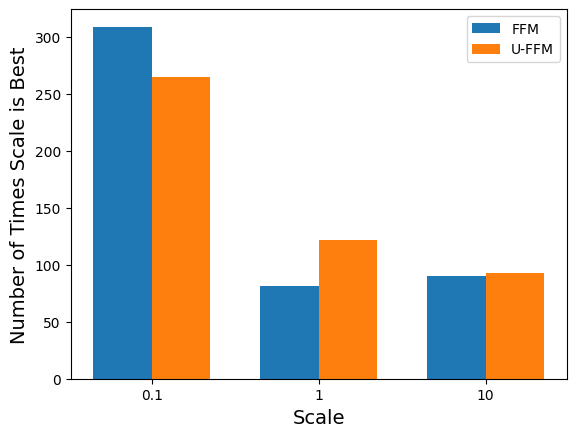

In [43]:
### only keep the ffn and uffn method

ffn_experiments_data = experiments_data.sel(dict(method=["ffn"]))
uffn_experiments_data = experiments_data.sel(dict(method=["uffn"]))

### print a histogram of how often each scale is the best across datasets, repetitions and learning rates
ffn_min_loss_index = ffn_experiments_data.argmin(dim='scales')
uffn_min_loss_index = uffn_experiments_data.argmin(dim='scales')


## count the number of times each scale is the best
ffn_min_loss_index  = ffn_min_loss_index.values.flatten()
unique, counts = np.unique(ffn_min_loss_index, return_counts=True)

uffn_min_loss_index  = uffn_min_loss_index.values.flatten()
unique, counts_uffn = np.unique(uffn_min_loss_index, return_counts=True)


### plot the histogram of the counts for ffn and uffn in separate bars with different colors


fig, ax = plt.subplots()
bar_width = 0.35
bar_widths = np.arange(len(unique))

ax.bar(bar_widths, counts, bar_width, label='FFM', color=colors[0])
ax.bar(bar_widths + bar_width, counts_uffn, bar_width, label='U-FFM', color=colors[1])

ax.set_xticks(bar_widths + bar_width / 2)
ax.set_xticklabels(["0.1", "1", "10"])
ax.set_xlabel("Scale", fontsize=14)

ax.set_ylabel("Number of Times Scale is Best", fontsize=14)
ax.legend()

#plt.title("Best Scale across Datasets, Repetitions and Learning Rates", fontsize=14)

plt.savefig("../../../assets/v2full_dataset_ffm_scale_histogram.pdf", format="pdf", bbox_inches='tight')
plt.show()


